### Problem Statement:  
Can we find which variables are the most important to look for while buying/investing in a house in Ames Iowa? Can we create a predictive model to predict house sale prices dependent on certain variables

### Models used/tested:
Linear Regression  
Ridge Regression (Final model chosen at end based on RMSE and R Squared scores)  
Lasso Regression 

### Importing Libraries and Data

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [96]:
# Read
df_train = pd.read_csv('./datasets/train.csv') # building model around
df_test = pd.read_csv('./datasets/test.csv') # set to use to generate predictions using model


### Preliminary Exploring Data

In [97]:
# Checking size of train data
df_train.shape

(2051, 81)

In [98]:
# Checking size of test data
df_test.shape

(879, 80)

In [99]:
# Seeing the missing column (SalePrice)
set(df_train.columns) - set(df_test.columns)

{'SalePrice'}

In [100]:
# Seeing the first few lines of data
df_train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [101]:
# Checking for all the different variables allowed to use
df_train.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [102]:
# Set row names to be equal to the Id numbers
df_train.set_index('Id', inplace = True)
df_test.set_index('Id', inplace = True)

## Data Cleaning and dealing with Null Values

In [103]:
# Checking for null values
df_train.isnull().sum().sort_values(ascending = False)

Pool QC            2042
Misc Feature       1986
Alley              1911
Fence              1651
Fireplace Qu       1000
Lot Frontage        330
Garage Qual         114
Garage Finish       114
Garage Cond         114
Garage Yr Blt       114
Garage Type         113
Bsmt Exposure        58
BsmtFin Type 2       56
Bsmt Cond            55
Bsmt Qual            55
BsmtFin Type 1       55
Mas Vnr Type         22
Mas Vnr Area         22
Bsmt Half Bath        2
Bsmt Full Bath        2
Garage Cars           1
Garage Area           1
Total Bsmt SF         1
Bsmt Unf SF           1
BsmtFin SF 2          1
BsmtFin SF 1          1
Year Built            0
Exterior 2nd          0
Exterior 1st          0
Roof Matl             0
                   ... 
Exter Qual            0
Heating               0
Foundation            0
Sale Type             0
Yr Sold               0
Mo Sold               0
Misc Val              0
Pool Area             0
Screen Porch          0
3Ssn Porch            0
Enclosed Porch  

In [104]:
# Creating the columns which will be dropped based on number of null values (ie, pool QC, since over 99% is missing 
# we can drop it)
dropColumns = ['Pool QC', 'Misc Feature', 'Alley', 'Pool Area']
df_train = df_train.drop(columns = df_train[dropColumns])

In [105]:
# Dropping same columns in test data
df_test = df_test.drop(columns = df_test[dropColumns])

In [106]:
# Checking to see if they dropped correctly
print(df_train.shape)
print(df_test.shape)

(2051, 76)
(879, 75)


In [107]:
# Creating list of ordinal variables
# List was found using data dictionary on kaggle
ordinal_cols = ['Lot Shape','Utilities','Land Slope','Exter Qual','Exter Cond',
               'Bsmt Cond','Bsmt Qual','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2',
               'Heating QC','Electrical','Kitchen Qual','Functional','Fireplace Qu',
                'Garage Finish','Garage Qual','Garage Cond','Paved Drive','Fence']

In [108]:
# Creating dictionary to convert ordinal variables
# This section of code was slightly adapted by my classmate Noah Christiansen
rank_dict = {'Lot Shape': {'IR1': 1, 'Reg': 4, 'IR2': 2, 'IR3': 3},
             'Utilities': {'AllPub':4, 'NoSeWa':2, 'NoSewr':3, 'ELO':1},
             'Land Slope': {'Gtl':3, 'Sev':2, 'Mod':1},
             'Exter Qual': {'Gd':4, 'TA':3, 'Ex':5, 'Fa':2,'Po':1},
             'Exter Cond': {'TA':3, 'Gd':4, 'Fa':2, 'Ex':5, 'Po':1},
             'Bsmt Cond': {'TA':3, 'Gd':4, np.nan:0, 'Fa':2, 'Po':1, 'Ex':5},
             'Bsmt Qual': {'TA':3, 'Gd':4, 'Fa':2, np.nan:0, 'Ex':5, 'Po':1},
             'Bsmt Exposure': {'No':1, 'Gd':4, 'Av':3, np.nan:0, 'Mn':2},
             'BsmtFin Type 1': {'GLQ':6, 'Unf':1, 'ALQ':5, 'Rec':3, np.nan:0, 'BLQ':4, 'LwQ':2},
             'BsmtFin Type 2': {'Unf':1, 'Rec':3, np.nan:0, 'BLQ':4, 'GLQ':6, 'LwQ':2, 'ALQ':5},
             'Heating QC': {'Ex':5, 'TA':3, 'Gd':4, 'Fa':2, 'Po':1},
             'Electrical': {'SBrkr':5, 'FuseF':3, 'FuseA':4, 'FuseP':2, 'Mix':1,np.nan:0},
             'Kitchen Qual': {'Gd':4, 'TA':3, 'Fa':2, 'Ex':5,'Po':1},
             'Functional': {'Typ':8, 'Mod':5, 'Min2':6, 'Maj1':4, 'Min1':7, 'Sev':2, 'Sal':1, 'Maj2':3},
             'Fireplace Qu': {np.nan:0, 'TA':3, 'Gd':4, 'Po':1, 'Ex':5, 'Fa':2},
             'Garage Finish': {'RFn':2, 'Unf':1, 'Fin':3, np.nan:0},
             'Garage Qual': {'TA':3, 'Fa':2, np.nan:0, 'Gd':4, 'Ex':5, 'Po':1},
             'Garage Cond': {'TA':3, 'Fa':2, np.nan:0, 'Po':1, 'Gd':4, 'Ex':5},
             'Paved Drive': {'Y':3, 'N':1, 'P':2},
             'Fence': {np.nan:0, 'MnPrv':3, 'GdPrv':4, 'GdWo':2, 'MnWw':1}
            }

In [109]:
# created function to convert ordinals to numbers instead of strings
# This section of code was shared by my classmate Noah Christiansen
def rank_ordinals(df, ordinalList):
    for col in ordinalList:
        df[col] = df[col].map(rank_dict[col])
    return df

rank_ordinals(df_train, ordinal_cols)
rank_ordinals(df_test, ordinal_cols).head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Fence,Misc Val,Mo Sold,Yr Sold,Sale Type
Id,,,,,,,,,,,,,,,,,,,,,
2658,902301120,190,RM,69.0,9142,Pave,4,Lvl,4,Inside,...,0,60,112,0,0,0,0,4,2006,WD
2718,905108090,90,RL,NaN,9662,Pave,1,Lvl,4,Inside,...,170,0,0,0,0,0,0,8,2006,WD
2414,528218130,60,RL,58.0,17104,Pave,1,Lvl,4,Inside,...,100,24,0,0,0,0,0,9,2006,New
1989,902207150,30,RM,60.0,8520,Pave,4,Lvl,4,Inside,...,0,0,184,0,0,0,0,7,2007,WD
625,535105100,20,RL,NaN,9500,Pave,1,Lvl,4,Inside,...,0,76,0,0,185,0,0,7,2009,WD


In [110]:
# Separating columns to categorical columns
catColumns = df_train.select_dtypes(include=['object']).columns
catColumns

Index(['MS Zoning', 'Street', 'Land Contour', 'Lot Config', 'Neighborhood',
       'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Foundation', 'Heating', 'Central Air', 'Garage Type', 'Sale Type'],
      dtype='object')

In [111]:
# Checking how many nominal columns there are
len(catColumns)

19

In [112]:
# Separating columns into numerical columns
numColumns = df_train.select_dtypes(include=['int64', 'float64']).columns
numColumnsTest = numColumns.drop('SalePrice')
numColumns

Index(['PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Lot Shape',
       'Utilities', 'Land Slope', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond',
       'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1',
       'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF',
       'Total Bsmt SF', 'Heating QC', 'Electrical', '1st Flr SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces',
       'Fireplace Qu', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars',
       'Garage Area', 'Garage Qual', 'Garage Cond', 'Paved Drive',
       'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch',
       'Screen Porch', 'Fence', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice'],
      dtype='object')

In [113]:
# Converting all null values in numerical columns to 0
df_train[numColumns] = df_train[numColumns].fillna(0)
df_test[numColumnsTest] = df_test[numColumnsTest].fillna(0)

In [114]:
# Checking to see if all null values have been removed properly
df_train[numColumns].isnull().sum().sort_values(ascending = False).head()

SalePrice          0
Low Qual Fin SF    0
1st Flr SF         0
Electrical         0
Heating QC         0
dtype: int64

In [115]:
# Checking to see if all null values have been removed properly in test data
df_test[numColumnsTest].isnull().sum().sort_values(ascending = False).head()

Yr Sold       0
Mo Sold       0
1st Flr SF    0
Electrical    0
Heating QC    0
dtype: int64

In [116]:
# Dealing with null values in categorical columns
df_train[catColumns] = df_train[catColumns].fillna('NA')
df_test[catColumns] = df_test[catColumns].fillna('NA')

In [117]:
# Checking to see if all null values have been removed properly
df_train.isnull().sum().sort_values(ascending = False).head()

SalePrice       0
Exter Cond      0
Roof Style      0
Roof Matl       0
Exterior 1st    0
dtype: int64

In [118]:
# Checking to see if all null values have been removed properly in test data
df_test.isnull().sum().sort_values(ascending = False).head()

Sale Type       0
Year Built      0
Roof Style      0
Roof Matl       0
Exterior 1st    0
dtype: int64

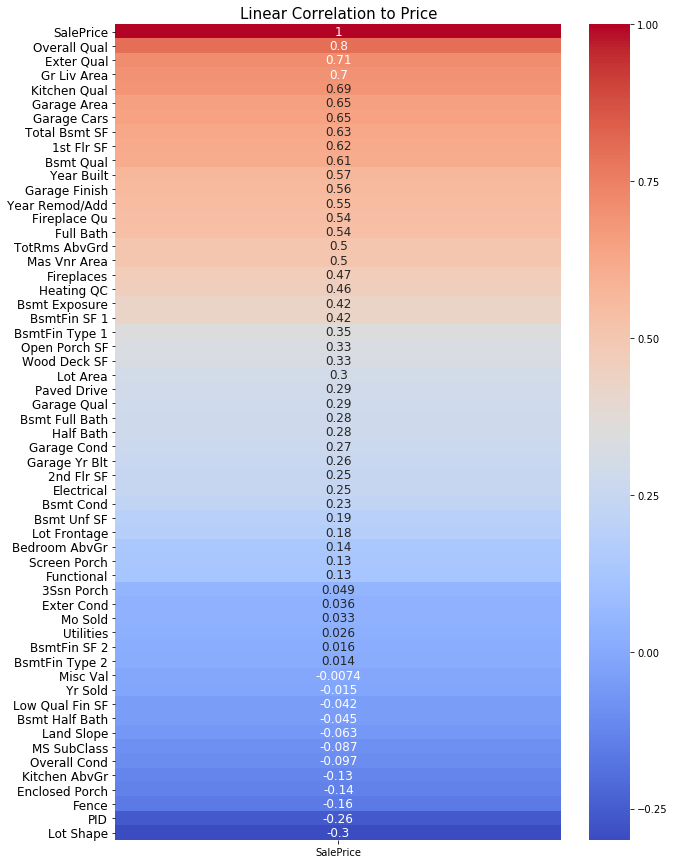

In [119]:
# Checking to see correlation heatmap to see what might be a large driver for saleprice
plt.figure(figsize=(10,15))
plt.yticks(fontsize = 12)
plt.title('Linear Correlation to Price', fontsize = 15)


sns.heatmap(df_train.corr()[['SalePrice']].sort_values(by = 'SalePrice', ascending = False), 
            annot = True, cmap = 'coolwarm',annot_kws={"size": 12})


In [120]:
# After checking the correlation for the variables, we will only focus on the variables which have higher than 0.5 
# linear correlation
# All ordinal variables have been changed to a ranking system to give accurate representation of the variable
# Dummy variables were created for all categorical variables
# All these data variables 

From initial heatmap, couple of variables will have to be explored further:

- Overall Qual 
- Gr Liv Area 
- Garage Area 
- Garage Cars 
- Total Bsmt SF 
- 1st Fl SF, 2nd Fl SF 
- Year Built 
- Year Remod/Built 
- Full Bath 
- TotRms Abv Gr 
- Fireplaces 
- BsmtFin SF1

Other categorical data will have to be explored with dummy variables.

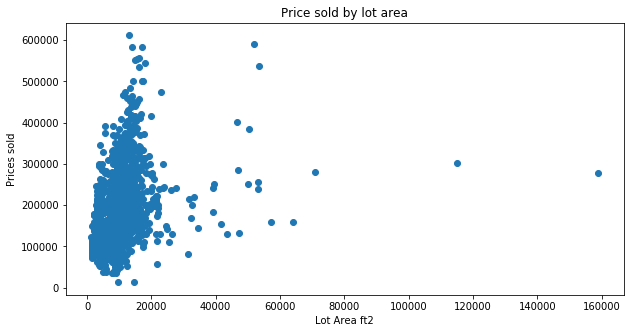

In [121]:
# Exploring data with higher correlations (Lot Area):
plt.figure(figsize = (10, 5))
plt.xlabel('Lot Area ft2')
plt.ylabel('Prices sold')
plt.title('Price sold by lot area')
plt.scatter(df_train['Lot Area'], df_train['SalePrice'])

# Semi linear relationship can be seen

In [122]:
# Removing outliers for lot area
mask = df_train['Lot Area'] > 30000
print(df_train[mask].shape)

# Since it only has 23 columns, this is less than 1% of the total data
df_train = df_train.drop(index = df_train[mask].index)

(25, 76)


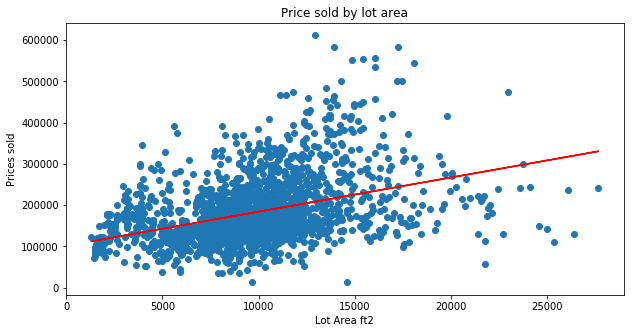

In [123]:
# Exploring data with higher correlations (Lot Area):
plt.figure(figsize = (10, 5))
plt.xlabel('Lot Area ft2')
plt.ylabel('Prices sold')
plt.title('Price sold by lot area')
plt.scatter(df_train['Lot Area'], df_train['SalePrice'])
b, m = polyfit(df_train['Lot Area'], df_train['SalePrice'], 1)
plt.plot(df_train['Lot Area'], b + m * df_train['Lot Area'], '-', color = 'red')
# Linear relationship can be seen once outliers have been removed

In [124]:
# Creating a new column with total sq footage 
totalSQ = pd.DataFrame(df_train[['Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Garage Area']])
totalSQ['Total'] = totalSQ['Total Bsmt SF'] + totalSQ['1st Flr SF'] + totalSQ['2nd Flr SF'] + totalSQ['Garage Area'] 
totalSQ['SalePrice'] = df_train['SalePrice']
totalSQ.head()

,Total Bsmt SF,1st Flr SF,2nd Flr SF,Garage Area,Total,SalePrice
Id,,,,,,
109,725.0,725,754,475.0,2679.0,130500
544,913.0,913,1209,559.0,3594.0,220000
153,1057.0,1057,0,246.0,2360.0,109000
318,384.0,744,700,400.0,2228.0,174000
255,676.0,831,614,484.0,2605.0,138500


In [125]:
# Repeating process for test data
totalSQTest = pd.DataFrame(df_test[['Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Garage Area']])
totalSQTest['Total'] = totalSQTest['Total Bsmt SF'] + totalSQTest['1st Flr SF'] + totalSQTest['2nd Flr SF'] + totalSQTest['Garage Area'] 
totalSQTest.head()

,Total Bsmt SF,1st Flr SF,2nd Flr SF,Garage Area,Total
Id,,,,,
2658,1020,908,1020,440,3388
2718,1967,1967,0,580,4514
2414,654,664,832,426,2576
1989,968,968,0,480,2416
625,1394,1394,0,514,3302


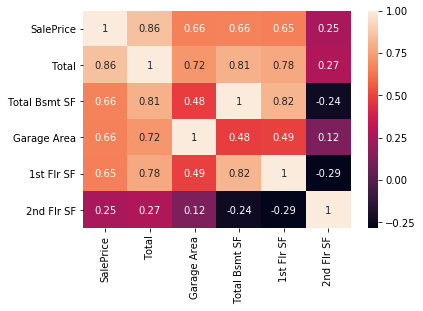

In [126]:
# Seeing correlation between total square footage as well as individual breakdown by price
sns.heatmap(totalSQ.corr()[['SalePrice', 'Total', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF']].sort_values(by = 'SalePrice', ascending = False), annot = True)

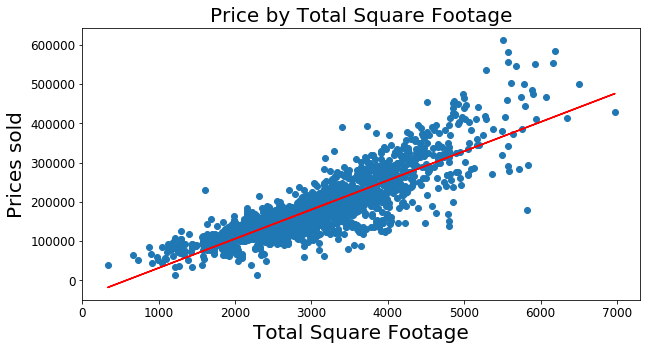

In [127]:
# Creating scatterplot for total square footage vs price
plt.figure(figsize = (10, 5))
plt.xlabel('Total Square Footage', fontsize = 20)
plt.ylabel('Prices sold', fontsize = 20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Price by Total Square Footage', fontsize = 20)
plt.scatter(totalSQ['Total'], totalSQ['SalePrice'])
b, m = polyfit(totalSQ['Total'], totalSQ['SalePrice'], 1)
plt.plot(totalSQ['Total'], b + m * totalSQ['Total'], '-', color = 'red')

# Has generally good linear function

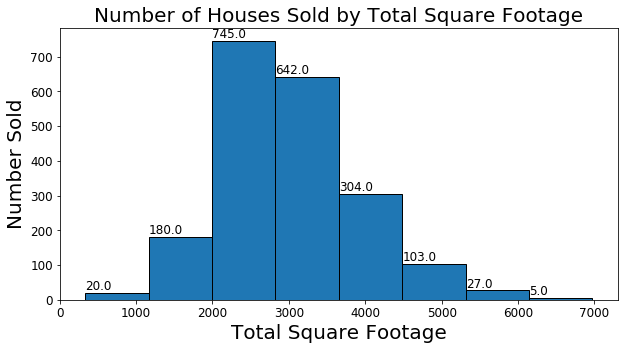

In [128]:
# Creating scatterplot for total square footage vs price
plt.figure(figsize = (10, 5))
plt.xlabel('Total Square Footage', fontsize = 20)
plt.ylabel('Number Sold', fontsize = 20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Number of Houses Sold by Total Square Footage', fontsize = 20)
arr = plt.hist(x=totalSQ['Total'], edgecolor='black', linewidth=1, bins = 8)
for i in range(8):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]), horizontalalignment='left', 
             verticalalignment = 'bottom', fontsize = 12)



In [129]:
# Checking the average house size as well as average price
print('Average house size:', totalSQ['Total'].mean())
print('Average price:', totalSQ['SalePrice'].mean())

Average house size: 3005.226554787759
Average price: 180622.81984205332


In [130]:
# Since it has a generally good trend as well as linear relationship, will add total sq to original dataframs
df_train['Total SF'] = totalSQ['Total']
df_test['Total SF'] = totalSQTest['Total']

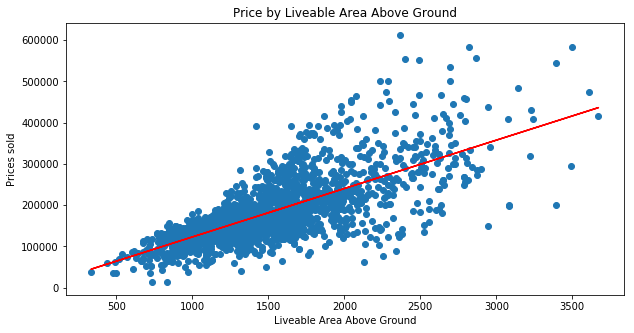

In [131]:
# Creating scatter plot for liveable areas
plt.figure(figsize = (10, 5))
plt.xlabel('Liveable Area Above Ground')
plt.ylabel('Prices sold')
plt.title('Price by Liveable Area Above Ground')
plt.scatter(df_train['Gr Liv Area'], df_train['SalePrice'])
b, m = polyfit(df_train['Gr Liv Area'], df_train['SalePrice'], 1)
plt.plot(df_train['Gr Liv Area'], b + m * df_train['Gr Liv Area'], '-', color = 'red')
# Has generally good linear function, after other outliers have been removed

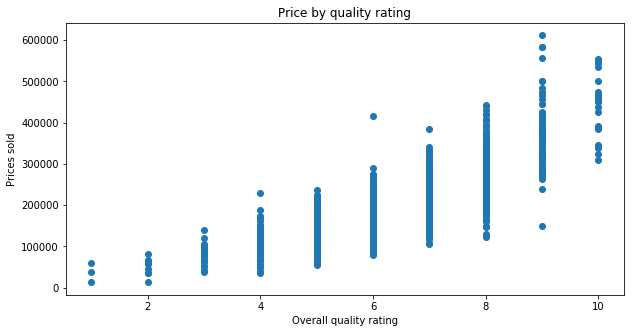

In [132]:
# Exploring data with higher correlations (overall quality):
plt.figure(figsize = (10, 5))
plt.xlabel('Overall quality rating')
plt.ylabel('Prices sold')
plt.title('Price by quality rating')
plt.scatter(df_train['Overall Qual'], df_train['SalePrice'])

# Can see linear correlation between quality of house and price

In [133]:
# Creating dummy variables for the neighborhood variable to check 
overQual = pd.get_dummies(df_train['Overall Qual'])
overQual['SalePrice'] = df_train['SalePrice']

In [134]:
# Finding the average price by neighborhood
overMeans = []
for column in overQual.columns:
    mask = df_train['Overall Qual'] == column
    temp = df_train[mask]['SalePrice'].mean()
    overMeans.append(temp)

/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [135]:
# Creating new dataframe for easier manipulation
overallQualMean = pd.DataFrame()
overallQualMean['Overall Qual'] = overQual.columns.values
overallQualMean['Average Price'] = overMeans
overallQualMean.drop(index = 10, inplace = True)
overallQualMean = overallQualMean.sort_values('Average Price')

In [136]:
# Checking dataframe and seeing average prices
overallQualMean

,Overall Qual,Average Price
0,1,37800.000000
1,2,51081.000000
2,3,79570.142857
3,4,106415.936306
4,5,134597.194991
5,6,161916.686747
6,7,202932.133178
7,8,269835.729839
8,9,367048.146667
9,10,440774.809524


<BarContainer object of 10 artists>

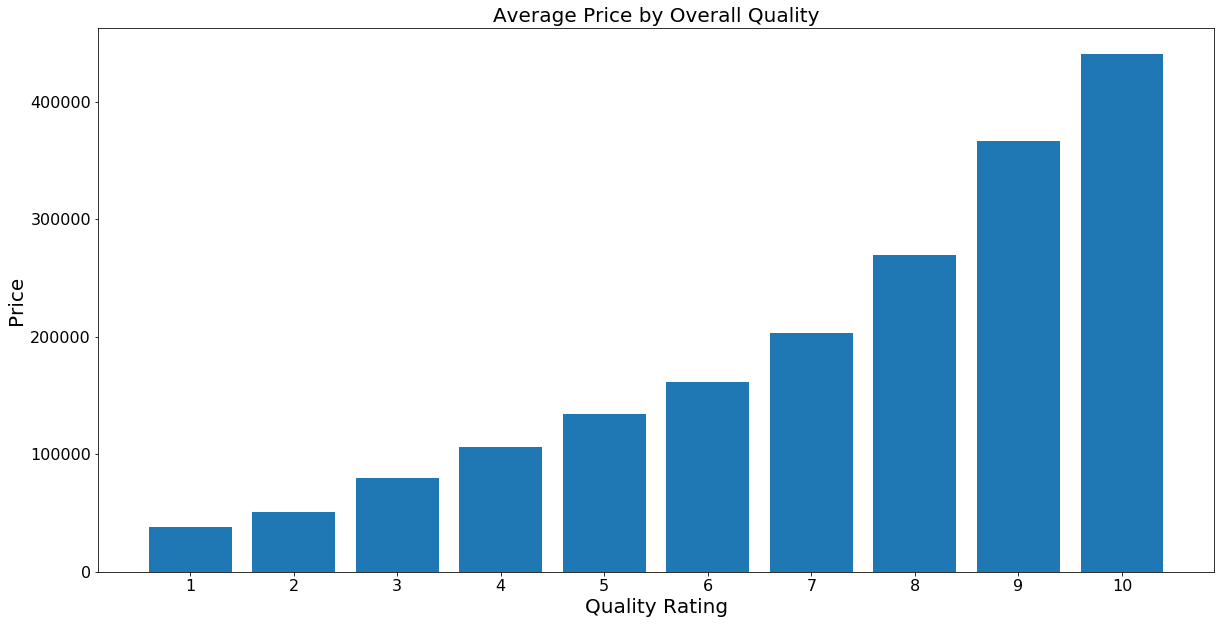

In [137]:
# Assigning lists to be used in histogram plot, and plotting as well
overallList = list(overallQualMean['Overall Qual'].values)
avgPriceList = list(overallQualMean['Average Price'].values)
plt.figure(figsize = (20, 10))
plt.xticks(range(1,11), fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('Quality Rating', fontsize = 20)
plt.ylabel('Price', fontsize = 20)
plt.title('Average Price by Overall Quality', fontsize = 20)
plt.bar(overallList, avgPriceList,align='center')

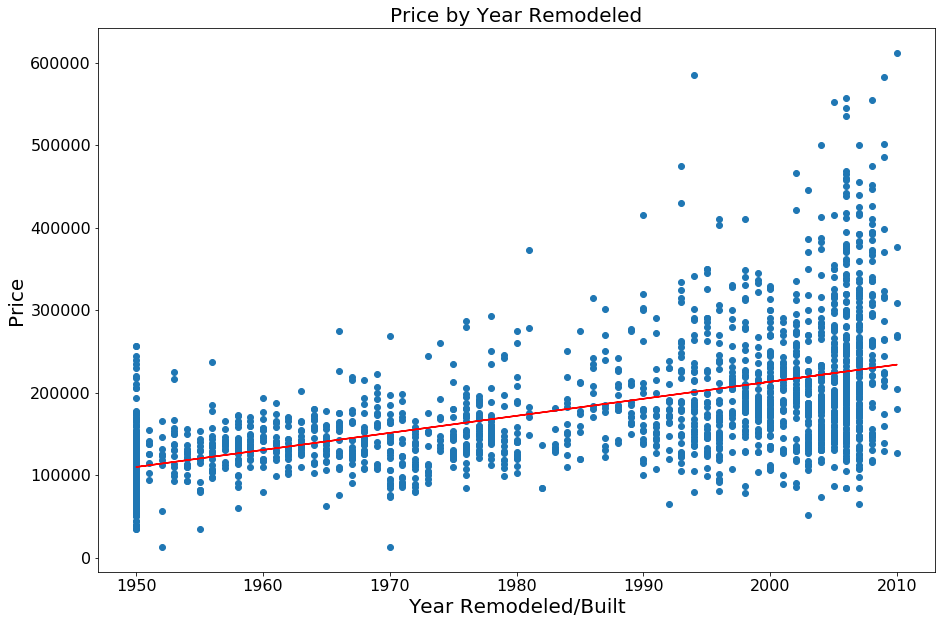

In [138]:
# Exploring Year Remod/Add data, since this is a bigger indicator than year built, it is a bigger driver for price
plt.figure(figsize = (15, 10))
plt.xlabel('Year Remodeled/Built', fontsize = 20)
plt.ylabel('Price', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Price by Year Remodeled', fontsize = 20)
plt.scatter(df_train['Year Remod/Add'], df_train['SalePrice'])
b, m = polyfit(df_train['Year Remod/Add'], df_train['SalePrice'], 1)
plt.plot(df_train['Year Remod/Add'], b + m * df_train['Year Remod/Add'], '-', color = 'red')
# Slight linear relatipnship can be see. More recent renovation = generally higher price

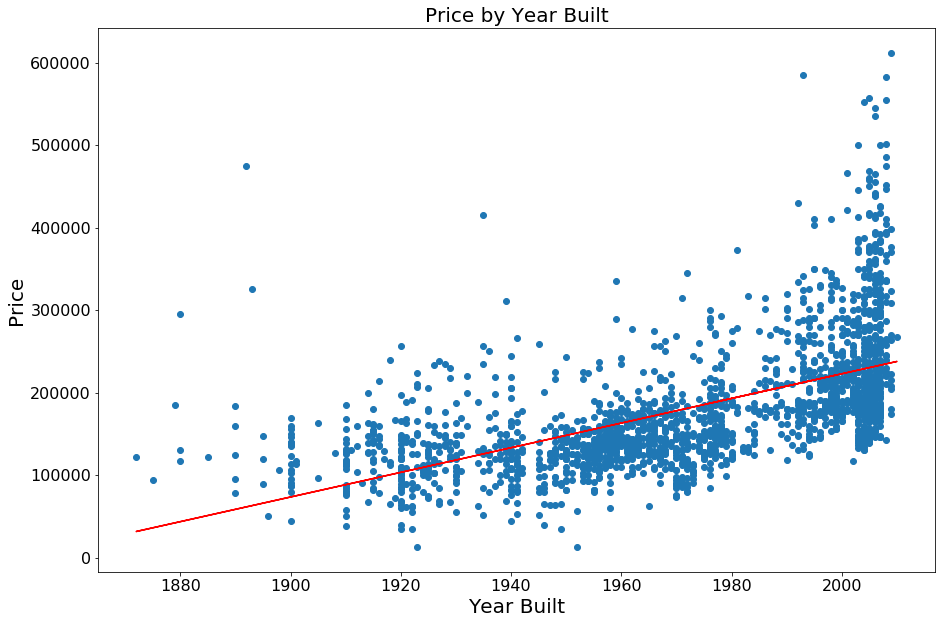

In [139]:
# Exploring Year Remod/Add data, since this is a bigger indicator than year built, it is a bigger driver for price
plt.figure(figsize = (15, 10))
plt.xlabel('Year Built', fontsize = 20)
plt.ylabel('Price', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Price by Year Built', fontsize = 20)
plt.scatter(df_train['Year Built'], df_train['SalePrice'])
b, m = polyfit(df_train['Year Built'], df_train['SalePrice'], 1)
plt.plot(df_train['Year Built'], b + m * df_train['Year Built'], '-', color = 'red')
# Slight linear relationship can be see. More recent renovation = generally higher price

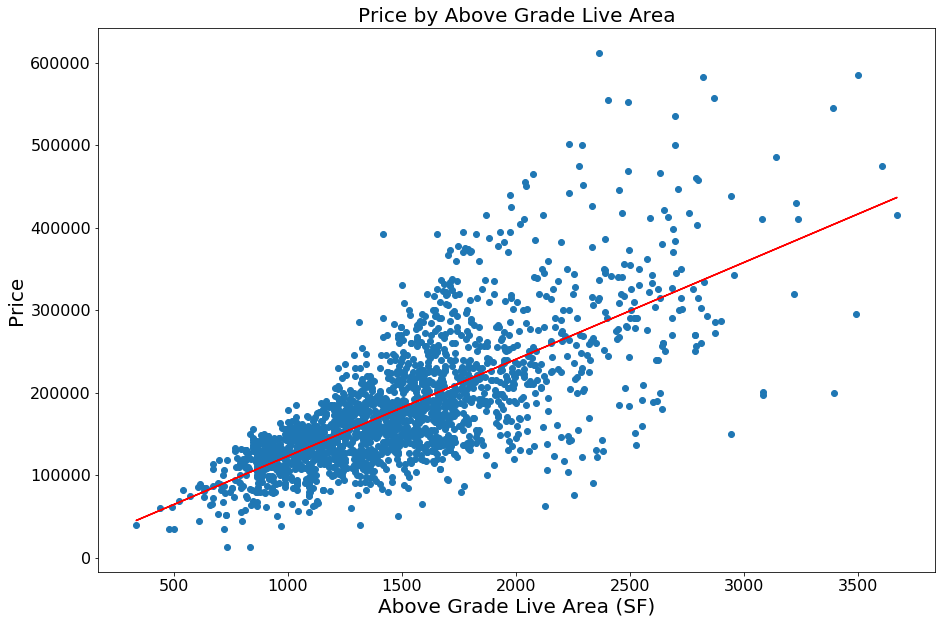

In [140]:
# Exploring above grade living area
plt.figure(figsize = (15, 10))
plt.xlabel('Above Grade Live Area (SF)', fontsize = 20)
plt.ylabel('Price', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Price by Above Grade Live Area', fontsize = 20)
plt.scatter(df_train['Gr Liv Area'], df_train['SalePrice'])
b, m = polyfit(df_train['Gr Liv Area'], df_train['SalePrice'], 1)
plt.plot(df_train['Gr Liv Area'], b + m * df_train['Gr Liv Area'], '-', color = 'red')

# Slight linear relationship can be see. More recent renovation = generally higher price

In [141]:
# Creating dummy variables for the neighborhood variable
neighborhoods = pd.get_dummies(df_train['Neighborhood'])
neighborhoods['SalePrice'] = df_train['SalePrice']

In [142]:
# Finding the average price by neighborhood
neighMeans = []
for column in neighborhoods.columns:
    mask = df_train['Neighborhood'] == column
    temp = df_train[mask]['SalePrice'].mean()
    neighMeans.append(temp)

In [143]:
# Creating new dataframe for easier manipulation
neighborMean = pd.DataFrame()
neighborMean['Neighborhoods'] = neighborhoods.columns.values
neighborMean['Average Price'] = neighMeans
neighborMean.drop(index = 28, inplace = True)
neighborMean = neighborMean.sort_values('Average Price')

In [144]:
# Checking neighborhoods vs the average price
neighborMean

,Neighborhoods,Average Price
13,MeadowV,100231.250000
11,IDOTRR,101103.188406
2,BrDale,103371.052632
20,OldTown,124691.586420
3,BrkSide,127022.697368
7,Edwards,128800.114286
21,SWISU,134758.875000
12,Landmrk,137000.000000
22,Sawyer,137181.909910
16,NPkVill,140476.470588


<BarContainer object of 28 artists>

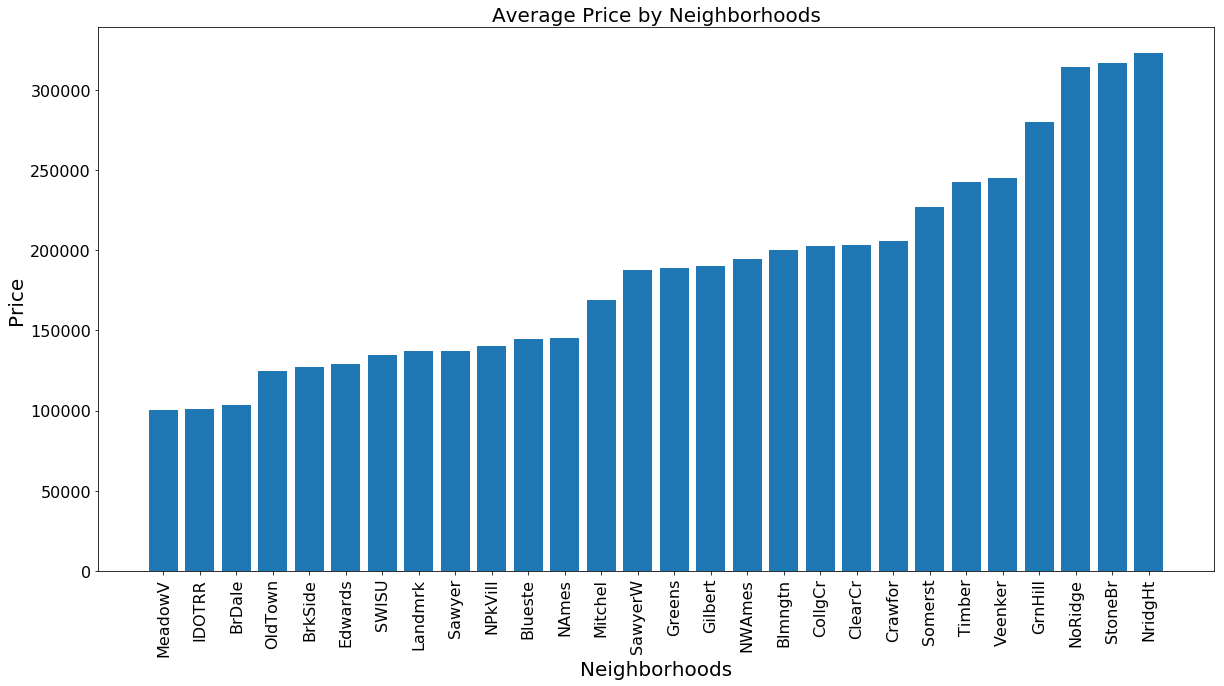

In [145]:
# Assigning lists to be used in histogram plot, and plotting as well
neghborhoodList = list(neighborMean['Neighborhoods'].values)
avgPriceList = list(neighborMean['Average Price'].values)
plt.figure(figsize = (20, 10))
plt.xticks(rotation='vertical', fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('Neighborhoods', fontsize = 20)
plt.ylabel('Price', fontsize = 20)
plt.title('Average Price by Neighborhoods', fontsize = 20)
plt.bar(neghborhoodList, avgPriceList,align='center')

In [146]:
# Create dummies for all categorical values
dummyCat = pd.get_dummies(df_train[catColumns]).columns.tolist()
df_train = pd.get_dummies(df_train, columns = catColumns)

In [147]:
# Create dummies for all categorical values
dummyCatTest = pd.get_dummies(df_test[catColumns]).columns.tolist()
df_test = pd.get_dummies(df_test, columns = catColumns)

In [148]:
# Need to ensure that data that can be found in train match the ones that can be found in test otherwise the data
# will not be able to be split properly during modeling section
# Setting columns to remove from train 
toRemoveTrain = list(set(df_train)-set(df_test))
toRemoveTrain.remove('SalePrice')


In [149]:
# Setting columnes to remove from test
toRemoveTest = list(set(df_test)-set(df_train))


In [150]:
# Creating dummy categories list to add to features later on
dummyCat = list(set(dummyCat) - set(toRemoveTrain))

## Model

### Baseline Model:

In [151]:
# Setting train data for baseline model. For the baseline, we will only be using total square footage. 
X = df_train['Total SF']
y = df_train['SalePrice']

In [152]:
# Train - Test Split for baseline model
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [153]:
# Code for baseline model, just using sale price and tota
from sklearn.dummy import DummyRegressor

# Instantiate
base_mean = DummyRegressor(strategy = 'mean')

# Fit
base_mean = base_mean.fit(X_train, y_train)

# Get Predictions
y_hat_base_train = base_mean.predict(X_train)
y_hat_base_test = base_mean.predict(X_test)

# Calculate RMSE
print("Train RMSE score:", np.sqrt(mean_squared_error(y_train, y_hat_base_train)))
print("Test RMSE score:", np.sqrt(mean_squared_error(y_test, y_hat_base_test)))

Train RMSE score: 78317.51990991617
Test RMSE score: 78049.56326025724


## Linear Regression Model

In [154]:
# Setting train data
features = ['Overall Qual', 'Total SF', 'Year Remod/Add', 'Year Built']
features += dummyCat
features += ordinal_cols
X = df_train[features]
y = df_train['SalePrice']

In [155]:
# Train - Test Split for baseline model
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [156]:
# Building linear regression model

# Instantiate
lr = LinearRegression()

# Fit
our_model = lr.fit(X_train, y_train)

# Generate predictions
y_hat_lr_train = our_model.predict(X_train)
y_hat_lr_test = our_model.predict(X_test)

# Calculate the Root Mean Squared Error for each (first one is train, and second one is test)
print("Train RMSE score:", np.sqrt(mean_squared_error(y_train, y_hat_lr_train)))
print("Test RMSE score:", np.sqrt(mean_squared_error(y_test, y_hat_lr_test)))

Train RMSE score: 22912.30678778766
Test RMSE score: 27021.363416105687


In [157]:
# Cross validation Scoring
cv_scores = cross_val_score(lr, X_train, y_train, cv = 5) # cv is how many cross validations

In [158]:
# Cross validation score means
cv_scores.mean()

0.8892129179845101

In [159]:
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.9144106399614671
0.8798541417063039


## Ridge Regression Model:

In [160]:
# Scaling X for the ridge and lasso regressions

ss = StandardScaler()
scaledX_train = ss.fit_transform(X_train)
scaledX_test = ss.fit_transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [161]:
# Ridge regression
# Instantiate.
# First test to use alpha = 10
ridge_model = Ridge(alpha = 10)

# Fit.
ridge_model.fit(scaledX_train, y_train)

# Generate predictions.
# ridge_preds = ridge_model.predict(X_overfit_test)
ridge_preds_train = ridge_model.predict(scaledX_train)

# Evaluate model using R2.
# print(r2_score(y_overfit_test, ridge_preds))
print(r2_score(y_train, ridge_preds_train))

0.9128951922925223


In [162]:
from sklearn.linear_model import RidgeCV

In [163]:
# Set up a list of ridge alphas to check.
r_alphas = np.logspace(0, 5, 100)
# Generates 100 values equally between 0 and 5,
# then converts them to alphas between 10^0 and 10^5.

# Cross-validate over our list of ridge alphas.
ridge_model = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)

# Fit model using best ridge alpha!
ridge_model = ridge_model.fit(scaledX_train, y_train)

In [164]:
# Here is the optimal value of alpha
ridge_optimal_alpha = ridge_model.alpha_
ridge_optimal_alpha

46.4158883361278

In [165]:
# Instantiate model.
our_model = Ridge(alpha=ridge_optimal_alpha)

# Fit model.
our_model.fit(scaledX_train, y_train)

# Generate predictions
ridge_opt_preds = our_model.predict(scaledX_test)
ridge_opt_preds_train = our_model.predict(scaledX_train)

# Evaluate model.
print("Train RMSE score:", np.sqrt(mean_squared_error(y_train, ridge_opt_preds_train)))
print("Test RMSE score:", np.sqrt(mean_squared_error(y_test, ridge_opt_preds)))
print(r2_score(y_test, ridge_opt_preds))
print(r2_score(y_train, ridge_opt_preds_train))

Train RMSE score: 23283.829944718746
Test RMSE score: 27303.219975588832
0.8773346157419605
0.9116124725508927


## Lasso Regression Model:

In [166]:
# Lasso Regression
from sklearn.linear_model import LassoCV

In [167]:
# Set up a list of Lasso alphas to check.
l_alphas = np.linspace(0.15, 1, 85)
# Generates 85 values equally between 0.15 and 1.

# Cross-validate over our list of Lasso alphas.
our_model = LassoCV(alphas=l_alphas, cv=5)

# Fit model using best ridge alpha!
our_model = our_model.fit(scaledX_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

In [168]:
# Here is the optimal value of alpha
lasso_optimal_alpha = our_model.alpha_
lasso_optimal_alpha

0.7672619047619048

In [169]:
# Generate predictions
lasso_model_preds = our_model.predict(scaledX_test)
lasso_model_preds_train = our_model.predict(scaledX_train)

# Evaluate model.
print("Train RMSE score:", np.sqrt(mean_squared_error(y_train, lasso_model_preds_train)))
print("Test RMSE score:", np.sqrt(mean_squared_error(y_test, lasso_model_preds)))
print(r2_score(y_test, lasso_model_preds))
print(r2_score(y_train, lasso_model_preds_train))

Train RMSE score: 22913.582082048026
Test RMSE score: 29712.942293099557
0.8547267654268395
0.9144011119241293


## Kaggle Predictions Submissions

In [170]:
# Creating kaggle test prediction stuff

X_kaggle = df_test[features] # Setting testing set of features

# Scaled x kaggle 
scaledX_kaggle = ss.fit_transform(X_kaggle)

X_kaggle['SalePrice'] = our_model.predict(scaledX_kaggle) # creating new column called saleprice which is what we want, 
# just have to apply already built model to this dataset


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [171]:
X_kaggle.drop(features, axis=1, inplace=True) # keeping only ID and the predicted sales price

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [172]:
# Checking to see if X_kaggle has been created properly
X_kaggle.head()

,SalePrice
Id,
2658,130121.084205
2718,182622.232711
2414,209627.376188
1989,123701.094146
625,172388.440446


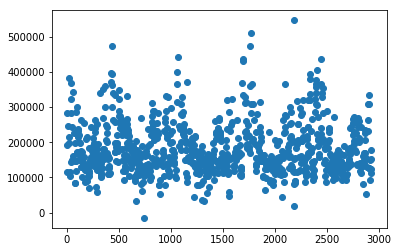

In [173]:
plt.scatter(X_kaggle.index, X_kaggle['SalePrice'])

In [174]:
# Exporting X_kaggle to csv file for submission at kaggle
#X_kaggle.to_csv("./datasets/Final_submission.csv")

In [175]:
# Using all total square footage, overall quality, year built, year remodeled, all the ordinal and categorical 
# variables will give the predicted prices. However, during actual house hunting, the best thing to do would be to 
# look only for the total square footage, overall quality, year built, and year remodeled as main variables since 
# majority of the other variables supports those four main variables. 